# Proyecto final - Entrega 1 
MINE-4101: Applied Data Science  
Universidad de los Andes  
Estudiantes: Alejandra Guerrero, Luis Enrique Garcia, Diego Alejandro Peña

In [1]:
# Importar librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re
from datetime import date

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

### Lectura de los datos

In [2]:
# Carga en memoria del archivo csv
ruta_datos='./datos/HomeData.csv'
df = pd.read_csv(ruta_datos, encoding='utf8')

In [3]:
# Visualización de los datos cargados
df

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.00,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0000,24.40,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503906,1452128306,1.599333,0.003233,1.599333,0.000050,0.104017,0.625033,0.041750,0.005233,0.008433,...,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503907,1452128307,1.924267,0.003217,1.924267,0.000033,0.422383,0.637733,0.042033,0.004983,0.008467,...,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503908,1452128308,1.978200,0.003217,1.978200,0.000050,0.495667,0.620367,0.042100,0.005333,0.008233,...,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
503909,1452128309,1.990950,0.003233,1.990950,0.000050,0.494700,0.634133,0.042100,0.004917,0.008133,...,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51


In [4]:
# Listado de columnas
df.dtypes

time                    object
use [kW]               float64
gen [kW]               float64
House overall [kW]     float64
Dishwasher [kW]        float64
Furnace 1 [kW]         float64
Furnace 2 [kW]         float64
Home office [kW]       float64
Fridge [kW]            float64
Wine cellar [kW]       float64
Garage door [kW]       float64
Kitchen 12 [kW]        float64
Kitchen 14 [kW]        float64
Kitchen 38 [kW]        float64
Barn [kW]              float64
Well [kW]              float64
Microwave [kW]         float64
Living room [kW]       float64
Solar [kW]             float64
temperature            float64
icon                    object
humidity               float64
visibility             float64
summary                 object
apparentTemperature    float64
pressure               float64
windSpeed              float64
cloudCover              object
windBearing            float64
precipIntensity        float64
dewPoint               float64
precipProbability      float64
dtype: o

In [5]:
# Tamaño del conjunto de datos
df.shape

(503911, 32)

### Transformaciones iniciales

Se identificará el total de valores nulos por cada columna y se procederán a eliminar aquellas filas que no aporten al análisis.

In [6]:
# Conteo de filas que poseen valores nulos por cada columna
df.isna().sum()

time                   0
use [kW]               1
gen [kW]               1
House overall [kW]     1
Dishwasher [kW]        1
Furnace 1 [kW]         1
Furnace 2 [kW]         1
Home office [kW]       1
Fridge [kW]            1
Wine cellar [kW]       1
Garage door [kW]       1
Kitchen 12 [kW]        1
Kitchen 14 [kW]        1
Kitchen 38 [kW]        1
Barn [kW]              1
Well [kW]              1
Microwave [kW]         1
Living room [kW]       1
Solar [kW]             1
temperature            1
icon                   1
humidity               1
visibility             1
summary                1
apparentTemperature    1
pressure               1
windSpeed              1
cloudCover             1
windBearing            1
precipIntensity        1
dewPoint               1
precipProbability      1
dtype: int64

In [7]:
# Eliminación de las filas que poseen el campo 'uso' nulo
df = df[df['use [kW]'].notna()]

Se cambiará el formato de la variable tiempo, ya que se encuentra en un formato que dificulta su interpretación, análisis y tratamiento.

In [8]:
df['time'] = pd.DatetimeIndex(pd.date_range('2016-01-01 05:00', periods=len(df),  freq='min'))
df.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,2016-01-01 05:01:00,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,2016-01-01 05:02:00,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,2016-01-01 05:03:00,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,2016-01-01 05:04:00,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


Se agregarán campos asociadas a la variable tiempo, a partir de los cuales se podría evaluar su relación con el consumo de energía

In [9]:
df['year'] = df['time'].apply(lambda x : x.year)
df['month'] = df['time'].apply(lambda x : x.month)
df['day'] = df['time'].apply(lambda x : x.day)
df['day of week'] = df['time'].apply(lambda x : x.day_name())
df['nday of week'] = df['time'].apply(lambda x : x.weekday()+1)
df['hour'] = df['time'].apply(lambda x : x.hour)
df['minute'] = df['time'].apply(lambda x : x.minute)
df.head()

,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,precipIntensity,dewPoint,precipProbability,year,month,day,day of week,nday of week,hour,minute
0,2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,0.0,24.4,0.0,2016,1,1,Friday,5,5,0
1,2016-01-01 05:01:00,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,0.0,24.4,0.0,2016,1,1,Friday,5,5,1
2,2016-01-01 05:02:00,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,0.0,24.4,0.0,2016,1,1,Friday,5,5,2
3,2016-01-01 05:03:00,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,0.0,24.4,0.0,2016,1,1,Friday,5,5,3
4,2016-01-01 05:04:00,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,0.0,24.4,0.0,2016,1,1,Friday,5,5,4


Se unirán aquellas columnas que representen el mismo concepto de consumo energético

In [10]:
# Revisión del consumo de energía para las categorías Furnace y Kitchen
df[['Furnace 1 [kW]', 'Furnace 2 [kW]', 'Kitchen 12 [kW]', 'Kitchen 14 [kW]', 'Kitchen 38 [kW]']].sum()

Furnace 1 [kW]     49993.062333
Furnace 2 [kW]     68924.395621
Kitchen 12 [kW]     1388.448483
Kitchen 14 [kW]     3539.012726
Kitchen 38 [kW]        4.725373
dtype: float64

In [11]:
# Unión de campos
df['Furnace [kW]'] = df[['Furnace 1 [kW]', 'Furnace 2 [kW]']].sum(axis=1)
df['Kitchen [kW]'] = df[['Kitchen 12 [kW]', 'Kitchen 14 [kW]', 'Kitchen 38 [kW]']].sum(axis=1)

La columna CloudCover debería ser de tipo float, pero cuenta con algunos valores nominales, los cuales serán sustituidos por su valor más próximo considerando que los datos están presentes con una frecuencia de un minuto.

In [12]:
# Total de filas con valor erróneo
df.loc[df['cloudCover']=='cloudCover'].shape

(58, 41)

In [13]:
# Sustitución del valor cloudCover
df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
df['cloudCover'] = df['cloudCover'].astype('float')
df['cloudCover'].unique()

array([0.75, 0.  , 1.  , 0.31, 0.44, 0.13, 0.19, 0.25, 0.16, 0.21, 0.15,
       0.14, 0.27, 0.28, 0.17, 0.05, 0.1 , 0.26, 0.29, 0.11, 0.09, 0.12,
       0.06, 0.02, 0.08, 0.04, 0.35, 0.22, 0.23, 0.54, 0.39, 0.03, 0.07,
       0.76, 0.62, 0.18, 0.79, 0.48, 0.24, 0.57, 0.41, 0.78, 0.2 , 0.77,
       0.46, 0.55, 0.01, 0.51, 0.47, 0.5 , 0.4 , 0.3 , 0.43, 0.33, 0.6 ,
       0.68, 0.66, 0.45, 0.34, 0.52, 0.67, 0.49, 0.37, 0.36, 0.61, 0.38,
       0.42, 0.53, 0.63, 0.32, 0.56, 0.58, 0.72, 0.73, 0.71, 0.64, 0.59])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 503910 entries, 0 to 503909
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   time                 503910 non-null  datetime64[ns]
 1   use [kW]             503910 non-null  float64       
 2   gen [kW]             503910 non-null  float64       
 3   House overall [kW]   503910 non-null  float64       
 4   Dishwasher [kW]      503910 non-null  float64       
 5   Furnace 1 [kW]       503910 non-null  float64       
 6   Furnace 2 [kW]       503910 non-null  float64       
 7   Home office [kW]     503910 non-null  float64       
 8   Fridge [kW]          503910 non-null  float64       
 9   Wine cellar [kW]     503910 non-null  float64       
 10  Garage door [kW]     503910 non-null  float64       
 11  Kitchen 12 [kW]      503910 non-null  float64       
 12  Kitchen 14 [kW]      503910 non-null  float64       
 13  Kitchen 38 [kW

### Revisión de la variable tiempo

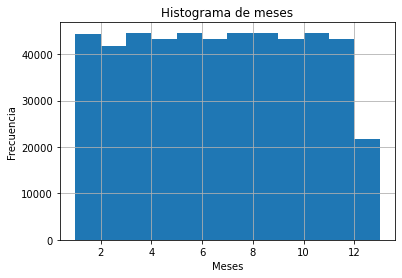

In [15]:
# Histograma para la variable Mes
intervalos = range(min(df['month']), max(df['month']) + 2)
plt.hist(x=df['month'], bins=intervalos)
plt.title('Histograma de meses')
plt.xlabel('Meses')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

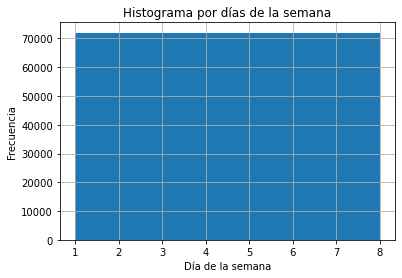

In [16]:
# Histograma para la variable día de la semana
intervalos = range(min(df['nday of week']), max(df['nday of week']) + 2)
plt.hist(x=df['nday of week'], bins=intervalos)
plt.title('Histograma por días de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

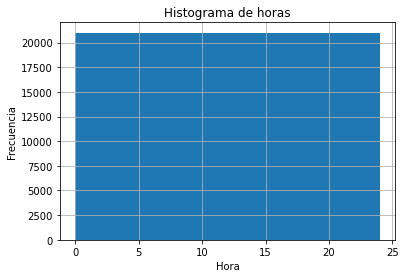

In [17]:
# Histograma para la variable Hora
intervalos = range(min(df['hour']), max(df['hour']) + 2)
plt.hist(x=df['hour'], bins=intervalos)
plt.title('Histograma de horas')
plt.xlabel('Hora')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

A partir de las gráficas anteriores se puede concluir que el conjunto de datos contiene una muestra significativa para cada uno de los meses del año, excepto para diciembre, por lo cual en dicho mes se podría presentar un sesgo. A nivel de día de la semana y franja horaria se identifica que no existen huecos de información, por lo cual son variables (junto con el mes) que se pueden considerar en el análisis.

### Revisión de la variable consumo

<AxesSubplot:xlabel='month'>

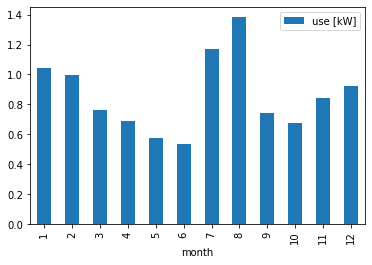

In [18]:
# Promedio del consumo de energía por mes del año
consumo_mes = df.groupby("month").agg({"use [kW]":"mean"}).reset_index()
consumo_mes.plot('month', kind = 'bar')

<AxesSubplot:xlabel='day'>

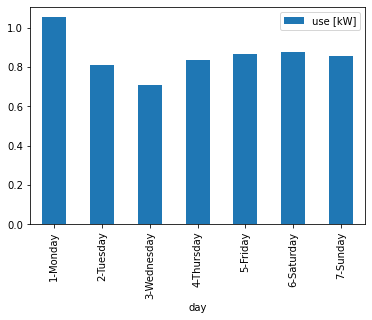

In [19]:
# Promedio del consumo de energía por día de la semana
consumo_dia = df.groupby(["nday of week", "day of week"]).agg({"use [kW]":"mean"}).reset_index()
consumo_dia['day'] = consumo_dia['nday of week'].apply(str) + '-' + consumo_dia['day of week']
consumo_dia.plot('day', 'use [kW]', kind = 'bar')

<AxesSubplot:xlabel='hour'>

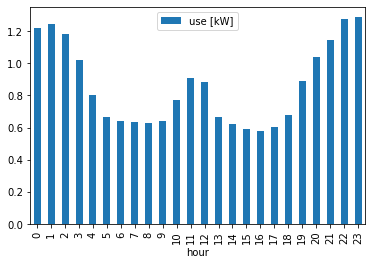

In [20]:
# Promedio del consumo de energía por hora de la semana
consumo_hora = df.groupby("hour").agg({"use [kW]":"mean"}).reset_index()
consumo_hora.plot('hour', kind = 'bar')

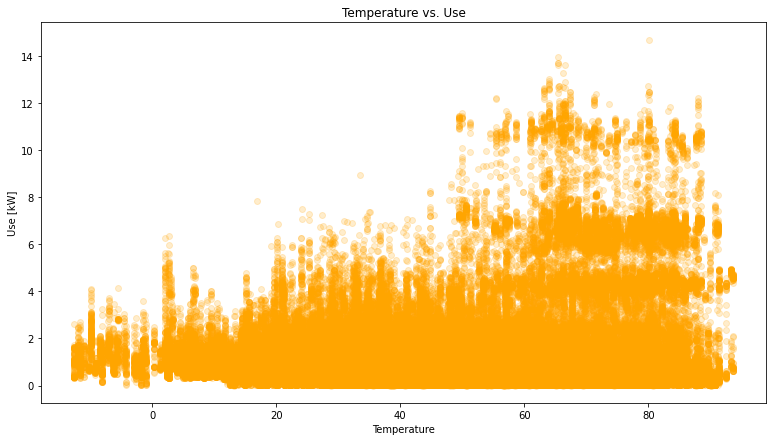

In [21]:
# Temperatura comparado contra el consumo de energía
plt.figure(figsize = (13, 7))
plt.scatter(df['temperature'], df['use [kW]'], alpha = 0.2, color = 'orange')
plt.title('Temperature vs. Use')
plt.xlabel('Temperature')
plt.ylabel('Use [kW]')
plt.show()

El promedio del consumo de energía es mayor en los meses de julio y agosto, lo cual podría relacionarse con que suelen ser los meses con mayores temperaturas. A nivel de día de la semana se identifica un incremento en el consumo de energía para el día lunes y una posterior caída en los días martes y miércoles. Finalmente, se evidencia un aumento en el consumo de energía en horas de la noche u oscuridad, que corresponde con el momento del día en el cual las personas pasan más tiempo en sus hogares y hacen uso de bombillas, electrodomésticos para fines de entretenimiento, entre otros.

### Revisión de las variables categóricas

Dentro del conjunto de datos existen dos variables categóricas que resumen las condiciones climáticas en el minuto en que se lleva a cabo el consumo de energía. A continuación se verificará la calidad de datos de los campos icon y summary.

<AxesSubplot:xlabel='icon'>

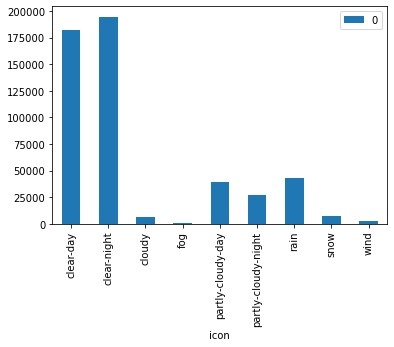

In [22]:
# Diagrama de frecuencias para la columna icon
consumo_icon = df.groupby("icon").size().reset_index()
consumo_icon.plot('icon', kind = 'bar')

<AxesSubplot:xlabel='summary'>

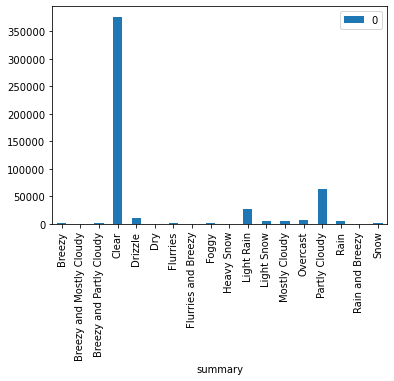

In [23]:
# Diagrama de frecuencias para la columna summary
consumo_sum = df.groupby("summary").size().reset_index()
consumo_sum.plot('summary', kind = 'bar')

Gran parte de los datos se encuentran catalogados con la condición climática "Clear-day", "Clear-night o "Clear". Al no haber una mayor distribución, se podría suponer que los datos no fueron clasificados correctamente y por tanto, estos campos no permiten crear hipótesis potenciales asociadas al consumo de energía eléctrica.

### Revision de las variables de consumo por electrodoméstico

In [24]:
# Agrupación por mes de los campos que contienen el consumo por electrodoméstico
resumen_consumo = df.groupby("month").agg({"Dishwasher [kW]":"mean", "Furnace [kW]":"mean", "Home office [kW]":"mean", "Fridge [kW]":"mean", "Wine cellar [kW]":"mean", 
                                           "Garage door [kW]":"mean", "Kitchen [kW]":"mean", "Barn [kW]":"mean", "Well [kW]":"mean", "Microwave [kW]":"mean", 
                                           "Living room [kW]":"mean"}).reset_index()

In [25]:
# Campos que contienen el consumo por electrodoméstico
campos = resumen_consumo.columns[1:]

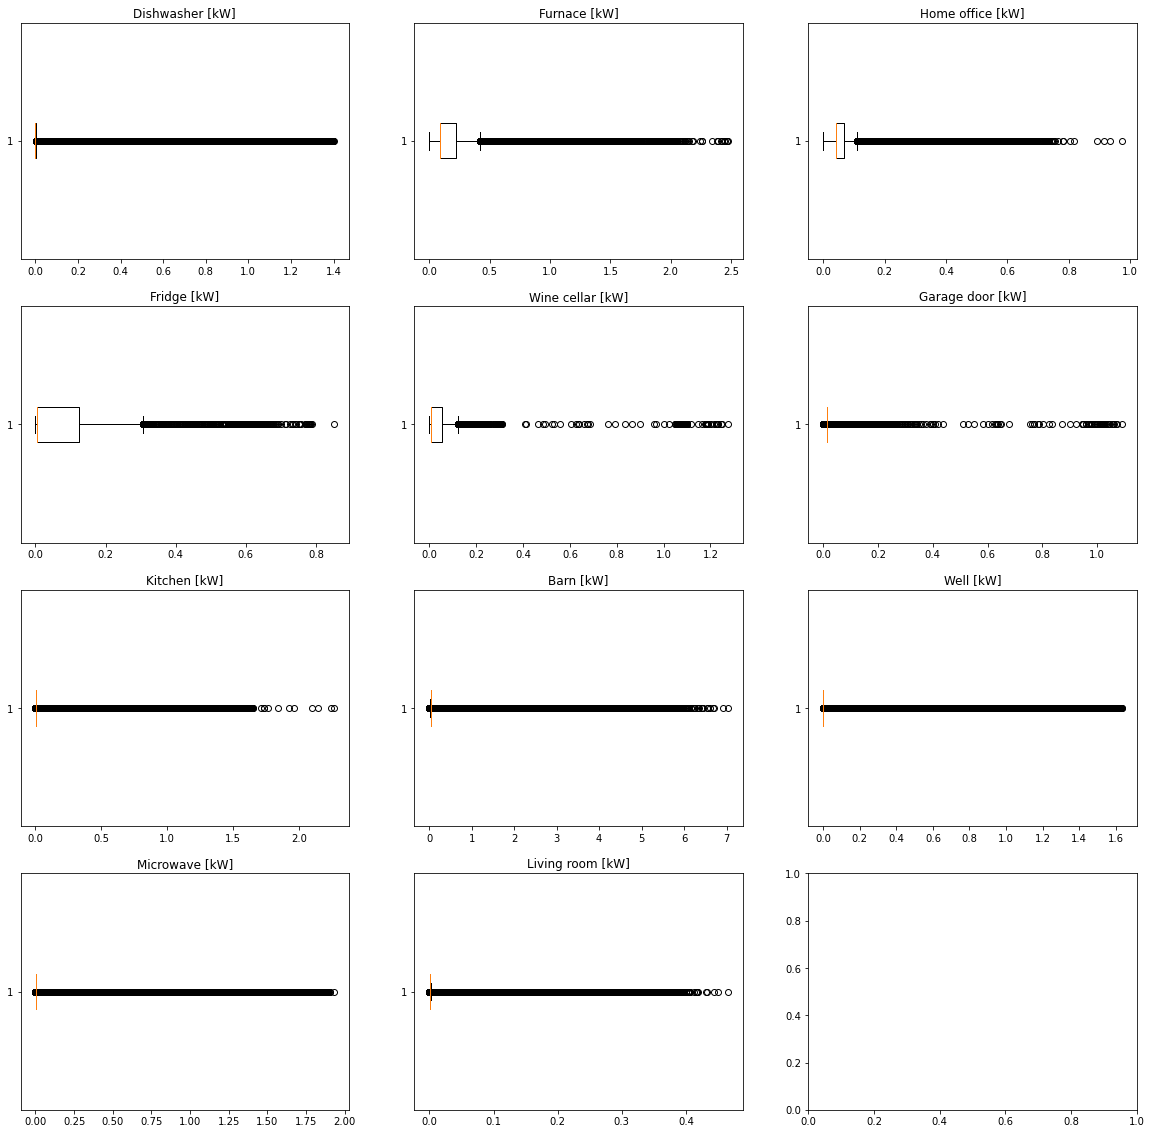

In [26]:
# Distribución del consumo por aparato eléctrico
col = 3
rows = int(np.ceil(len(campos)/col))
figure, axis = plt.subplots(rows, col, figsize=(20, 20))
j=0

for i in campos:
    x, y = int(j/col), int(j%col)
    axis[x, y].boxplot(df[i], vert=False)
    axis[x, y].set_title(i)    
    j += 1

plt.show()

Los diagramas de caja representan los datos como si existieran muchos outliers. Sin embargo, este es el comportamiento esperado considerando que el consumo suele ser esporádico. Por ejemplo, la puerta del garaje suele estar abierta o cerrada, pero en muy pocos momentos del día cambia de estado, registrando un consumo de energía. Por otro lado, el refrigerador suele permanecer conectado consumiendo constantemente electricidad; lo cual se relaciona con una caja y cuartiles más grandes.

In [27]:
meses = range(1, 12+1)

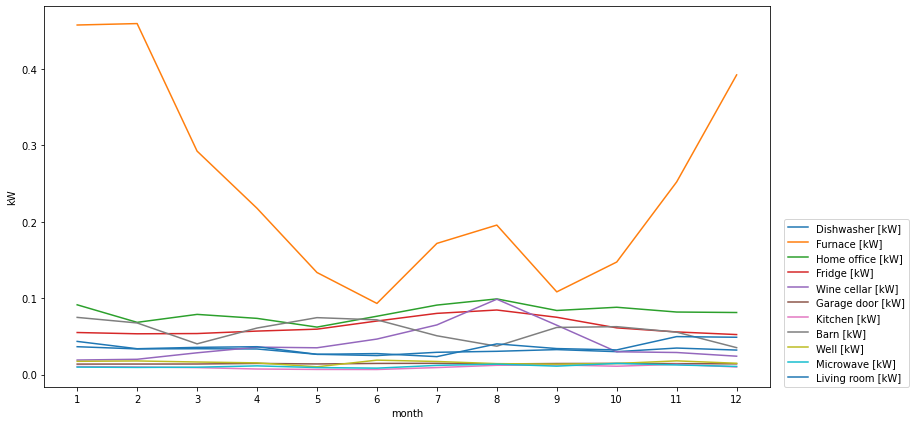

In [28]:
# Representación gráfica del consumo mensual por electrodoméstico o aparato en particular
plt.figure(figsize = (13, 7))

for i in campos:
    plt.plot(resumen_consumo['month'], resumen_consumo[i], linestyle='-', label=i)

plt.xlabel('month')
plt.ylabel('kW')
plt.xticks(meses)
plt.legend(loc=(1.02, 0))
plt.show()

La variable Furnace tiene valores más grandes en comparación con los otros campos. A primera vista, se podría asumir que impacta fuertemente el consumo total de energía. Con el fin de evaluar el comportamiento de los otros aparatos eléctricos, se omite Furnace del análisis siguiente.

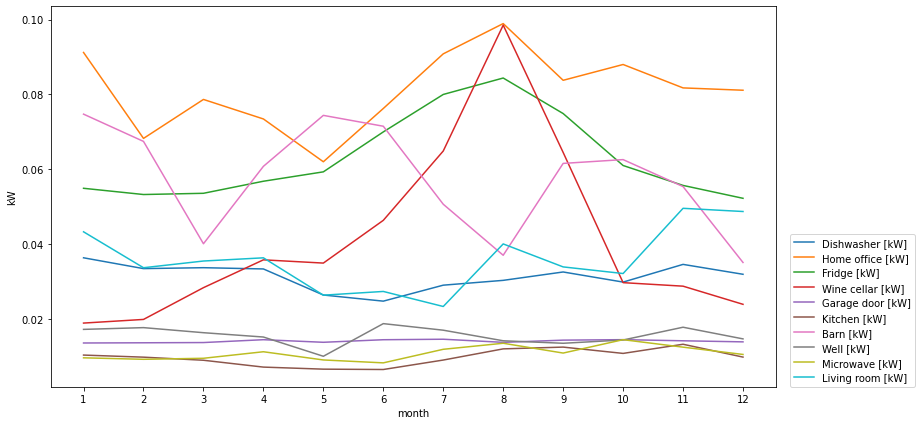

In [29]:
# Representación gráfica del consumo mensual por electrodoméstico, omitiendo Furnace
plt.figure(figsize = (13, 7))

for i in campos:
    if i != 'Furnace [kW]':
        plt.plot(resumen_consumo['month'], resumen_consumo[i], linestyle='-', label=i)

plt.xlabel('month')
plt.ylabel('kW')
plt.xticks(meses)
plt.legend(loc=(1.02, 0))
plt.show()

Como se observa en la gráfica previa, algunos electrodomésticos como refrigeradores o calefacción aumentan su consumo en los meses de mayores temperaturas (julio y agosto). Otros aparatos como la puerta del garaje, el horno microondas o aparatos de cocina tienen el mismo comportamiento durante el año y en consecuencia no afectan el consumo.

In [30]:
# Agrupación por hora de los campos que contienen el consumo por electrodoméstico
resumen_consumo = df.groupby("hour").agg({"Dishwasher [kW]":"mean", "Furnace [kW]":"mean", "Home office [kW]":"mean", "Fridge [kW]":"mean", "Wine cellar [kW]":"mean", 
                                           "Garage door [kW]":"mean", "Kitchen [kW]":"mean", "Barn [kW]":"mean", "Well [kW]":"mean", "Microwave [kW]":"mean", 
                                           "Living room [kW]":"mean"}).reset_index()

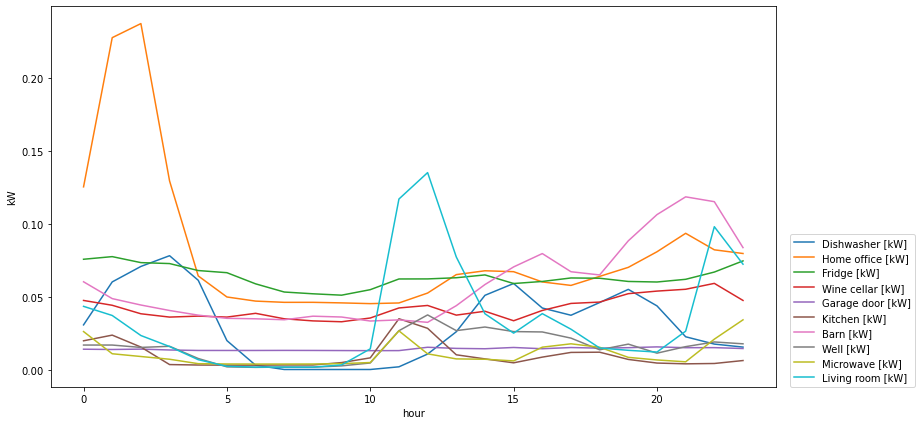

In [31]:
# Representación gráfica del consumo diario por electrodoméstico o aparato en particular
plt.figure(figsize = (13, 7))

for i in campos:
    if i != 'Furnace [kW]':
        plt.plot(resumen_consumo['hour'], resumen_consumo[i], linestyle='-', label=i)

plt.xlabel('hour')
plt.ylabel('kW')
#plt.xticks(meses)
plt.legend(loc=(1.02, 0))
plt.show()

La representación por horas del consumo muestra que existe una relación entre la hora y el consumo de energía por motivos de entretenimiento (living room), preparación de alimentos (kitchen y microwave), organización después de alimentarse (dishwasher). Sin embargo, no es claro el comportamiento del campo Home Office.

### Comparación entre el consumo de energía y la generación de energía

In [32]:
# Agrupación por mes del consumo vs generación de energía
resumen_consumo = df.groupby("month").agg({"use [kW]":sum, "gen [kW]":sum}).reset_index()

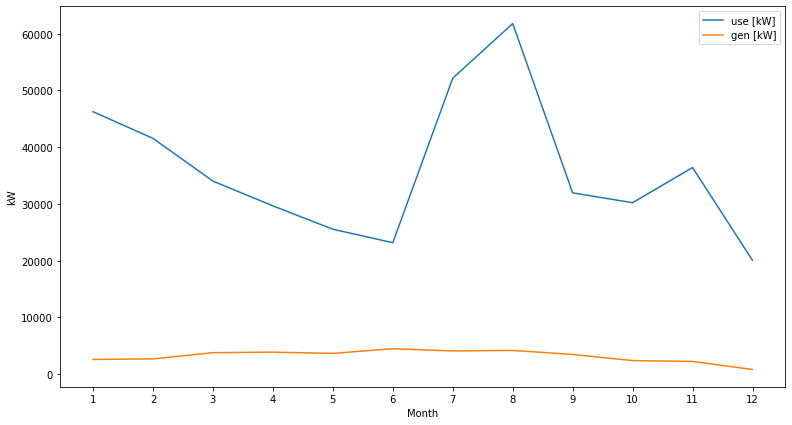

In [33]:
# Representación gráfica por mes del consumo vs generación de energía
plt.figure(figsize = (13, 7))

plt.plot(resumen_consumo['month'], resumen_consumo['use [kW]'], linestyle='-', label='use [kW]')
plt.plot(resumen_consumo['month'], resumen_consumo['gen [kW]'], linestyle='-', label='gen [kW]')

plt.xlabel('Month')
plt.ylabel('kW')
plt.xticks(meses)
plt.legend(loc = 'upper right')
plt.show()

La generación y captura de paneles solares no contrarresta o responde a la demanda de electricidad de un usuario.

### Correlación entre campos cuantitativos

In [34]:
# Matriz de correlación
df.corr()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],...,dewPoint,precipProbability,year,month,day,nday of week,hour,minute,Furnace [kW],Kitchen [kW]
use [kW],1.000000,-0.131635,1.000000,0.196272,0.314776,0.489414,0.147520,0.149223,0.124506,0.026531,...,0.016040,-0.003317,NaN,-0.003207,0.007126,-0.020405,0.005240,-0.000313,0.513503,0.103777
gen [kW],-0.131635,1.000000,-0.131635,0.038204,-0.020461,-0.107684,-0.085421,-0.002862,0.062430,0.036328,...,0.089664,0.041192,NaN,-0.038014,0.038253,0.004404,0.410571,0.000239,-0.082863,-0.017690
House overall [kW],1.000000,-0.131635,1.000000,0.196272,0.314776,0.489414,0.147520,0.149223,0.124506,0.026531,...,0.016040,-0.003317,NaN,-0.003207,0.007126,-0.020405,0.005240,-0.000313,0.513503,0.103777
Dishwasher [kW],0.196272,0.038204,0.196272,1.000000,0.002023,-0.008349,0.065525,0.034020,-0.004619,-0.008958,...,-0.016099,0.008189,NaN,-0.003923,-0.013282,-0.011472,-0.015590,0.001156,-0.004197,0.003272
Furnace 1 [kW],0.314776,-0.020461,0.314776,0.002023,1.000000,0.240445,-0.019692,-0.042511,-0.096036,-0.022801,...,-0.301091,0.000344,NaN,-0.203171,0.016562,-0.008269,0.044010,-0.004350,0.774086,0.014000
Furnace 2 [kW],0.489414,-0.107684,0.489414,-0.008349,0.240445,1.000000,-0.008555,-0.032574,-0.052272,0.002969,...,-0.233404,0.007913,NaN,-0.151566,-0.010192,0.004287,-0.012865,-0.002724,0.800632,0.011417
Home office [kW],0.147520,-0.085421,0.147520,0.065525,-0.019692,-0.008555,1.000000,0.035013,0.003896,-0.013537,...,0.007594,-0.032861,NaN,0.031268,-0.022400,-0.080404,-0.196688,0.000381,-0.017735,0.007517
Fridge [kW],0.149223,-0.002862,0.149223,0.034020,-0.042511,-0.032574,0.035013,1.000000,0.076183,-0.002380,...,0.115169,0.004794,NaN,0.048400,0.000145,-0.006711,-0.023261,0.002344,-0.047486,0.011322
Wine cellar [kW],0.124506,0.062430,0.124506,-0.004619,-0.096036,-0.052272,0.003896,0.076183,1.000000,0.004393,...,0.298207,0.006571,NaN,0.134409,0.027662,0.035783,0.076454,0.000860,-0.093372,0.005218
Garage door [kW],0.026531,0.036328,0.026531,-0.008958,-0.022801,0.002969,-0.013537,-0.002380,0.004393,1.000000,...,0.008350,-0.006639,NaN,0.012905,-0.000984,0.006927,0.042341,-0.004231,-0.012138,-0.000467


<AxesSubplot:>

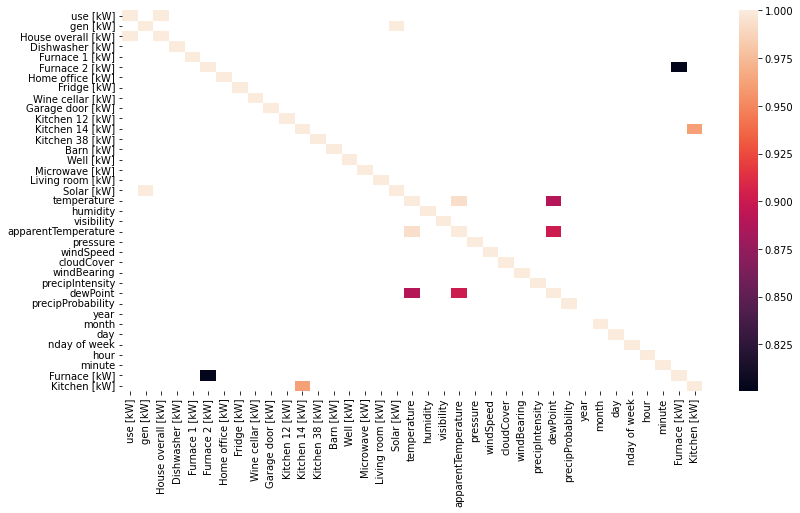

In [35]:
#Representación gráfica de la matriz de correlación filtrando por aquellas más significativas
plt.figure(figsize = (13, 7))
sns.heatmap(df.corr()[df.corr()>0.8])

Al analizar la gráfica de correlación, se decide eliminar variables que están altamente correlacionadas y por tanto no aportarían información relevante, por ejemplo: use y house overall, gen y solar, kitchen (campo totalizador) con kitchen 12-14 y 38, temperature con apparent temperature, y furnace (campo totalizador) con furnace 1 y 2.

In [36]:
df.drop(['Furnace 1 [kW]',
                'Furnace 2 [kW]',
                'Kitchen 12 [kW]',
                'Kitchen 14 [kW]',
                'Kitchen 38 [kW]',
                'apparentTemperature',
                'House overall [kW]',
                'gen [kW]', 
                'Solar [kW]',
                'icon',
                'summary',
                'year'
                ], axis=1, inplace=True, errors= 'ignore')

In [37]:
df.head()

,time,use [kW],Dishwasher [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Barn [kW],Well [kW],Microwave [kW],...,dewPoint,precipProbability,month,day,day of week,nday of week,hour,minute,Furnace [kW],Kitchen [kW]
0,2016-01-01 05:00:00,0.932833,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,...,24.4,0.0,1,1,Friday,5,5,0,0.082617,0.000567
1,2016-01-01 05:01:00,0.934333,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,...,24.4,0.0,1,1,Friday,5,5,1,0.084533,0.000567
2,2016-01-01 05:02:00,0.931817,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,...,24.4,0.0,1,1,Friday,5,5,2,0.083017,0.000617
3,2016-01-01 05:03:00,1.022050,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,...,24.4,0.0,1,1,Friday,5,5,3,0.175417,0.000650
4,2016-01-01 05:04:00,1.139400,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,...,24.4,0.0,1,1,Friday,5,5,4,0.300917,0.000783


<AxesSubplot:>

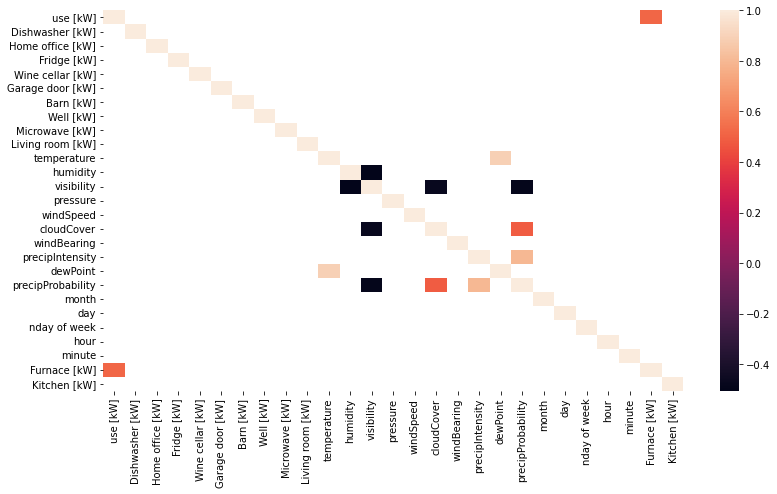

In [38]:
#Representación gráfica de la matriz de correlación filtrando por aquellas más significativas
plt.figure(figsize = (13, 7))
sns.heatmap(df.corr()[abs(df.corr())>0.45])

# Proyecto final - Entrega 2
MINE-4101: Applied Data Science  
Universidad de los Andes  
Estudiantes: Alejandra Guerrero, Luis Enrique Garcia, Diego Alejandro Peña

## Punto 1 [25%]: Preparación de Datos

En las transformaciones iniciales que hacían parte del análisis exploratorio de los datos se eliminaron columnas altamente correlacionadas, columnas con valores que nunca cambiaban y variables categóricas con etiquetas no confiables. Además, se crearon los siguientes campos partiendo del tiempo en el cual se registró el consumo: month, day, day_of_week, nday_of_week, hour, minute. 
Adicionalmente a lo anterior, vamos a generar dos nuevas variables: Temporada del Año ("Season") y Parte del Día (Noche, Mañana o Tarde), con el fin de agrupar períodos de tiempo que posean características particulares.

In [39]:
# Función que retorna la estación del año dada una fecha. Asumimos que las estaciones pueden tener ordinalidad.
def season(x):
    if x < pd.to_datetime("2016-3-21"): 
        return 0 # "Winter"
    elif x > pd.to_datetime("2016-3-20") and x < pd.to_datetime("2016-6-21"):
        return 1 # "Spring"
    elif x > pd.to_datetime("2016-6-21") and x < pd.to_datetime("2016-9-24"):
        return 2 # "Summer" 
    elif x > pd.to_datetime("2016-9-24") and x < pd.to_datetime("2016-12-23"):
        return 3 # "Autumn"
    else:
        return 0 # "Winter"

In [40]:
# Función que retorna el momento del día dada una hora. Asumimos que los momentos del día tienen ordinalidad.
def PartofDay(x):
    if x < 6: 
        return 0 # "Night"
    elif x < 12:
        return 1 # "Morning"
    elif x < 19:
        return 2 # "Afternoon"
    else:
        return 0 # "Night"

In [41]:
# Aplicacion de la función Season
df['Season']=df['time'].apply(season)

In [42]:
# Aplicacion de la función PartOfDay
df['Part of the Day']=df['hour'].apply(PartofDay)

In [43]:
# enc = OneHotEncoder(handle_unknown='ignore')
# salida = enc.fit(df)

In [44]:
# le = LabelEncoder()
# df['Season encoded']=le.fit_transform(df['Season'])
# df['Part of Day encoded']=le.fit_transform(df['Part of the Day'])

In [45]:
# Se define el dataframe que vamos a utilizar en la construcción de los diferentes modelos 
x = df[['Season', 'month', 'day','nday of week','Part of the Day', 'temperature','humidity','visibility','pressure','windSpeed','cloudCover','windBearing',
           'precipIntensity','dewPoint','precipProbability','Dishwasher [kW]', 'Home office [kW]', 'Fridge [kW]','Wine cellar [kW]','Garage door [kW]','Barn [kW]','Well [kW]',
           'Microwave [kW]','Living room [kW]','Furnace [kW]','Kitchen [kW]']]
y = df[['use [kW]']]

In [46]:
# Conjunto de datos a usar para entrenar los modelos
x

,Season,month,day,nday of week,Part of the Day,temperature,humidity,visibility,pressure,windSpeed,...,Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Furnace [kW],Kitchen [kW]
0,0,1,1,5,0,36.14,0.62,10.00,1016.91,9.18,...,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,0.001517,0.082617,0.000567
1,0,1,1,5,0,36.14,0.62,10.00,1016.91,9.18,...,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,0.001650,0.084533,0.000567
2,0,1,1,5,0,36.14,0.62,10.00,1016.91,9.18,...,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,0.001650,0.083017,0.000617
3,0,1,1,5,0,36.14,0.62,10.00,1016.91,9.18,...,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,0.001617,0.175417,0.000650
4,0,1,1,5,0,36.14,0.62,10.00,1016.91,9.18,...,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,0.001583,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503905,3,12,16,5,0,35.12,0.86,8.74,1011.49,6.72,...,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,0.000967,0.727683,0.000633
503906,3,12,16,5,0,35.12,0.86,8.74,1011.49,6.72,...,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,0.000933,0.729050,0.000600
503907,3,12,16,5,0,35.12,0.86,8.74,1011.49,6.72,...,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,0.001000,1.060117,0.000600
503908,3,12,16,5,0,35.12,0.86,8.74,1011.49,6.72,...,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,0.000950,1.116033,0.000650


## Punto 2 [15%]: Estrategia de Validación y Selección de Modelo

A continuación se segmentará el conjunto de datos en set de entrenamiento (80%) y set de pruebas (20%). Adicionalmente, se destina un 20% del set de entrenamiento para realizar la validación del modelo.

In [47]:
# Creación del set de pruebas y el set de entrenamiento
X_train_0, X_test, Y_train_0, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

# Dividiendo en set de entrenamiento en set de entrenamiento y set de validación
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train_0, Y_train_0, test_size = 0.2, random_state = 1)

Vale la pena revisar que los tres conjuntos de datos mantengan la misma distribución de datos. Se revisará la distribución de los datos por fecha y por target.

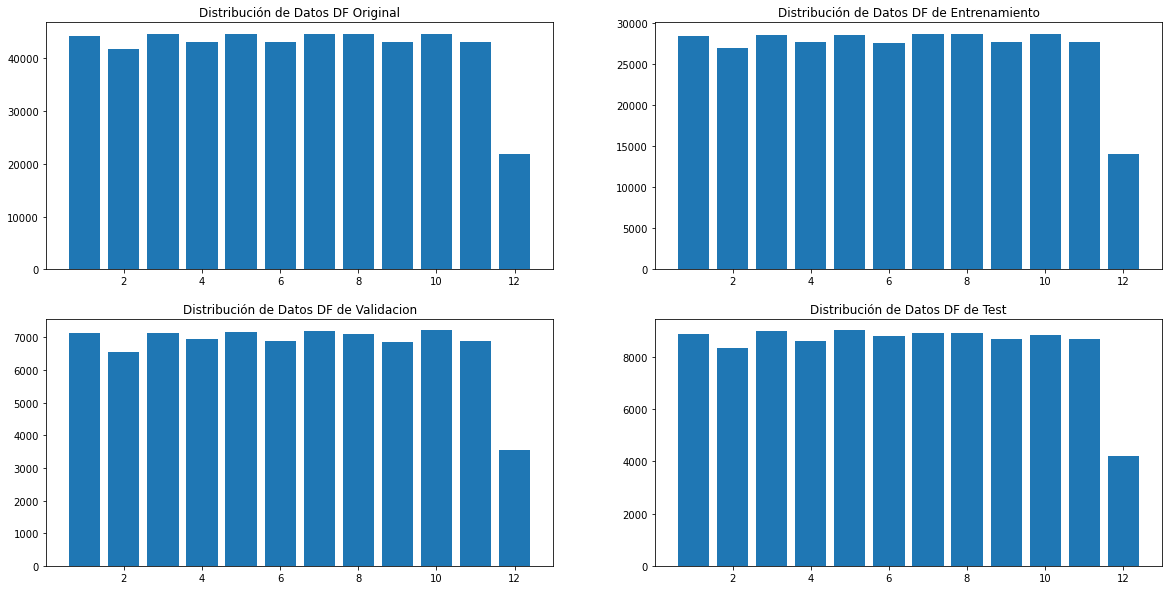

In [48]:
# Distribución de los datos por mes
figure, axis = plt.subplots(2, 2, figsize=(20, 10))

# Promedio del consumo de energía por mes del año del DF original
consumo_mes_NewDF = df.groupby("month").size().reset_index(name='num_registers')
axis[0, 0].bar(consumo_mes_NewDF['month'], consumo_mes_NewDF['num_registers'])
axis[0, 0].set_title('Distribución de Datos DF Original')

# Promedio del consumo de energía por mes del año del DF de entrenamiento
consumo_mes_train = X_train.groupby("month").size().reset_index(name='num_registers')
axis[0, 1].bar(consumo_mes_train['month'], consumo_mes_train['num_registers'])
axis[0, 1].set_title('Distribución de Datos DF de Entrenamiento')

# Promedio del consumo de energía por mes del año del DF de validacion
consumo_mes_valid = X_validation.groupby("month").size().reset_index(name='num_registers')
axis[1, 0].bar(consumo_mes_valid['month'], consumo_mes_valid['num_registers'])
axis[1, 0].set_title('Distribución de Datos DF de Validacion')

# Promedio del consumo de energía por mes del año del DF de test
consumo_mes_test = X_test.groupby("month").size().reset_index(name='num_registers')
axis[1, 1].bar(consumo_mes_test['month'], consumo_mes_test['num_registers'])
axis[1, 1].set_title('Distribución de Datos DF de Test')
    
plt.show()

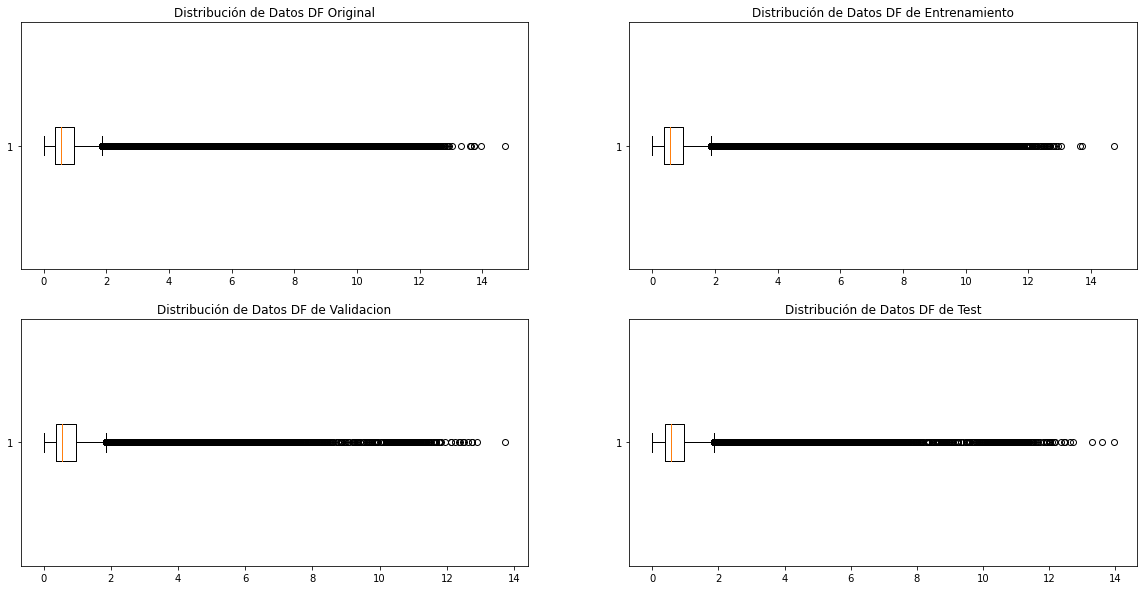

In [49]:
# Comportamiento de la variable target
figure, axis = plt.subplots(2, 2, figsize=(20, 10))

# Promedio del consumo de energía por mes del año del DF original
axis[0, 0].boxplot(y, vert=False)
axis[0, 0].set_title('Distribución de Datos DF Original')

# Promedio del consumo de energía por mes del año del DF de entrenamiento
axis[0, 1].boxplot(Y_train, vert=False)
axis[0, 1].set_title('Distribución de Datos DF de Entrenamiento')

# Promedio del consumo de energía por mes del año del DF de validacion
axis[1, 0].boxplot(Y_validation, vert=False)
axis[1, 0].set_title('Distribución de Datos DF de Validacion')

# Promedio del consumo de energía por mes del año del DF de test
axis[1, 1].boxplot(Y_test, vert=False)
axis[1, 1].set_title('Distribución de Datos DF de Test')
    
plt.show()

Con esto podemos validar que la distribución de los datos en los meses es muy similar entre los distintos dataframes. Por otro lado, la variable que se va a predecir también sigue un comportamiento parecido en los tres sets. 

## Punto 3 [20%]: Construcción del Modelo

Despues de la preparación de datos, vamos a correr varios modelos para identificar cuál se adapta mejor a las variables que tenemos. Luego de estandarizar los modelos, se procederá a crear modelos en los cuales se vaya aumentando el nivel de complejidad. Por otra parte, se usarán las bondades de gridSearch para identificar los parámetros que mejor optimizan los resultados del modelo; gridSearch se parametrizará con validación cruzada de 5 Folds para que rote la fracción de datos que usará para evaluar el modelo.

In [50]:
# Normalización de los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

### 1. Regresión Lineal

In [51]:
# Creación de un modelo de regresión lineal
regr = LinearRegression()
regr.fit(X_train_scaled, Y_train)

preds_train = regr.predict(X_train_scaled)
preds_valid = regr.predict(X_validation_scaled)
preds_test = regr.predict(X_test_scaled)

In [52]:
#Calculo del RMSE
MAE_LinealRegression_train=mean_absolute_error(Y_train, preds_train) 
MAE_LinealRegression_valid=mean_absolute_error(Y_validation, preds_valid)
MAE_LinealRegression_test=mean_absolute_error(Y_test, preds_test)

In [53]:
#Calculo del RMSE
RMSE_LinealRegression_train=np.sqrt(mean_squared_error(Y_train, preds_train))
RMSE_LinealRegression_valid=np.sqrt(mean_squared_error(Y_validation, preds_valid))
RMSE_LinealRegression_test=np.sqrt(mean_squared_error(Y_test, preds_test))
print(RMSE_LinealRegression_train, RMSE_LinealRegression_valid, RMSE_LinealRegression_test)

0.7274739016318977 0.7272637954531888 0.7232178641197787


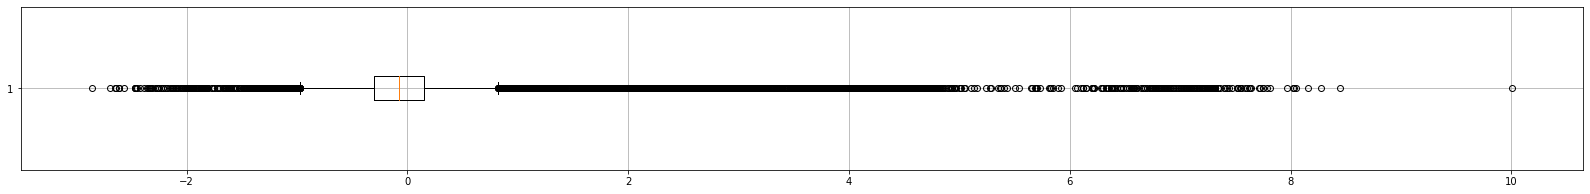

In [54]:
# Regresión lineal
# Diferencias entre el valor predicho y el valor real sobre el set de validación
plt.figure(figsize = (28, 3))
plt.boxplot((Y_validation - preds_valid), vert = False)
plt.grid()
plt.show()

A partir de lo anterior, se podría concluir que este modelo no presenta underfitting. Pero, se intentará disminuir el error.

### 2. Regresión polinomial sin regularización

In [55]:
# Selección del mejor modelo de regresión lineal con transformación polinomial de grado 1, 2 y 3, y sin regularización
estimators = [('polyRegression', PolynomialFeatures(degree=2, include_bias=False)),
              ('linearRegression', LinearRegression()),
              ]
pipe = Pipeline(estimators)

param_grid = dict(polyRegression__degree=[1, 2, 3],
                  polyRegression__include_bias=[False])

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=3)

grid_search.fit(X_train_scaled, Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END polyRegression__degree=1, polyRegression__include_bias=False;, score=0.524 total time=   0.3s
[CV 2/5] END polyRegression__degree=1, polyRegression__include_bias=False;, score=0.529 total time=   0.3s
[CV 3/5] END polyRegression__degree=1, polyRegression__include_bias=False;, score=0.527 total time=   0.3s
[CV 4/5] END polyRegression__degree=1, polyRegression__include_bias=False;, score=0.530 total time=   0.3s
[CV 5/5] END polyRegression__degree=1, polyRegression__include_bias=False;, score=0.528 total time=   0.3s
[CV 1/5] END polyRegression__degree=2, polyRegression__include_bias=False;, score=0.756 total time=   6.1s
[CV 2/5] END polyRegression__degree=2, polyRegression__include_bias=False;, score=0.763 total time=   6.0s
[CV 3/5] END polyRegression__degree=2, polyRegression__include_bias=False;, score=0.754 total time=   5.9s
[CV 4/5] END polyRegression__degree=2, polyRegression__include_bias=False;, score=0.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polyRegression',
                                        PolynomialFeatures(include_bias=False)),
                                       ('linearRegression',
                                        LinearRegression())]),
             param_grid={'polyRegression__degree': [1, 2, 3],
                         'polyRegression__include_bias': [False]},
             verbose=3)

In [56]:
print(grid_search.best_params_)

{'polyRegression__degree': 3, 'polyRegression__include_bias': False}


In [57]:
# Creación de un modelo con transformación polinómica de grado 3, ya que gridSearch indicó que era el mejor parámetro
poly_features = PolynomialFeatures(degree=3, include_bias=False)

x_poly_train = poly_features.fit_transform(X_train_scaled)
x_poly_test = poly_features.transform(X_test_scaled)
x_poly_valid = poly_features.transform(X_validation_scaled)

regr = LinearRegression()
regr.fit(x_poly_train, Y_train)

poly_train = regr.predict(x_poly_train)
poly_valid = regr.predict(x_poly_valid)
poly_test = regr.predict(x_poly_test)

In [58]:
#Calculo del MAE
MAE_PolynomialRegression_train=mean_absolute_error(Y_train, poly_train)
MAE_PolynomialRegression_valid=mean_absolute_error(Y_validation, poly_valid)
MAE_PolynomialRegression_test=mean_absolute_error(Y_test, poly_test)

In [59]:
#Calculo del RMSE
RMSE_PolynomialRegression_train=np.sqrt(mean_squared_error(Y_train, poly_train))
RMSE_PolynomialRegression_valid=np.sqrt(mean_squared_error(Y_validation, poly_valid))
RMSE_PolynomialRegression_test=np.sqrt(mean_squared_error(Y_test, poly_test))
print(RMSE_PolynomialRegression_train, RMSE_PolynomialRegression_valid, RMSE_PolynomialRegression_test)

0.39168138848358447 0.4019291837589824 0.4075135806655303


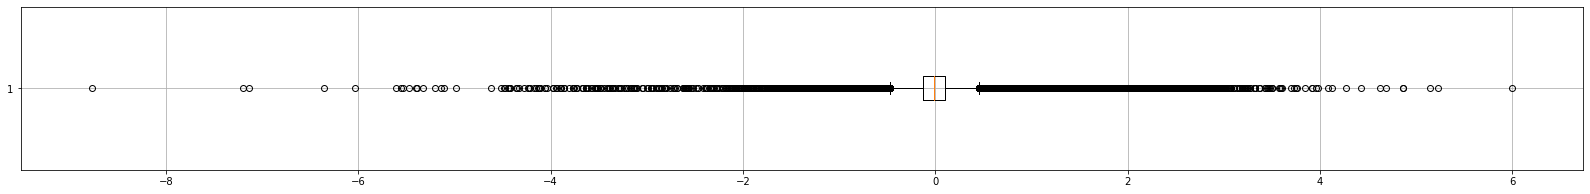

In [60]:
# Regresión polinómica de grado 3
# Diferencias entre el valor predicho y el valor real sobre el set de validación
plt.figure(figsize = (28, 3))
plt.boxplot((Y_validation - poly_valid), vert = False)
plt.grid()
plt.show()

A partir de lo anterior, se podría concluir que este modelo no presenta underfitting. Además, se comporta mejor que el modelo de regresión lineal simple. 
Como siguiente paso, se intentará disminuir el error aplicando regularización L1 y L2.

### 3. Regresión Polinomial con regularización LASSO (L1)

In [61]:
# Selección del mejor modelo de regresión con transformación polinomial de grado 1, 2 y 3, y regularización L1
estimators = [('polyRegression',PolynomialFeatures(degree=2, include_bias=False)),
              ('LassoRegression', Lasso(alpha=0.001)),
             ]

pipe = Pipeline(estimators)

param_grid = dict(polyRegression__degree=[1, 2],
                  LassoRegression__alpha= [0.001, 0.1, 1.0])

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=3)

grid_search.fit(X_train_scaled,Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END LassoRegression__alpha=0.001, polyRegression__degree=1;, score=0.524 total time=   1.6s
[CV 2/5] END LassoRegression__alpha=0.001, polyRegression__degree=1;, score=0.529 total time=   1.0s
[CV 3/5] END LassoRegression__alpha=0.001, polyRegression__degree=1;, score=0.527 total time=   1.0s
[CV 4/5] END LassoRegression__alpha=0.001, polyRegression__degree=1;, score=0.530 total time=   1.2s
[CV 5/5] END LassoRegression__alpha=0.001, polyRegression__degree=1;, score=0.529 total time=   0.8s
[CV 1/5] END LassoRegression__alpha=0.001, polyRegression__degree=2;, score=0.754 total time= 1.4min
[CV 2/5] END LassoRegression__alpha=0.001, polyRegression__degree=2;, score=0.761 total time= 1.3min
[CV 3/5] END LassoRegression__alpha=0.001, polyRegression__degree=2;, score=0.753 total time= 1.4min
[CV 4/5] END LassoRegression__alpha=0.001, polyRegression__degree=2;, score=0.763 total time= 1.2min
[CV 5/5] END LassoRegression__a

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polyRegression',
                                        PolynomialFeatures(include_bias=False)),
                                       ('LassoRegression',
                                        Lasso(alpha=0.001))]),
             param_grid={'LassoRegression__alpha': [0.001, 0.1, 1.0],
                         'polyRegression__degree': [1, 2]},
             verbose=3)

In [62]:
print(grid_search.best_params_)

{'LassoRegression__alpha': 0.001, 'polyRegression__degree': 2}


In [63]:
# Creación de un modelo con transformación polinómica de grado 2 y alpha 0.001, ya que gridSearch indicó que era el mejor parámetro
lasso_features = PolynomialFeatures(degree=2, include_bias=False)

x_lasso_train = lasso_features.fit_transform(X_train_scaled)
x_lasso_valid = lasso_features.transform(X_validation_scaled)
x_lasso_test = lasso_features.transform(X_test_scaled)

lasso_df = Lasso(alpha=0.001)
lasso_df.fit(x_lasso_train, Y_train)
df_lasso_training = lasso_df.predict(x_lasso_train)
df_lasso_valid = lasso_df.predict(x_lasso_valid)
df_lasso_test = lasso_df.predict(x_lasso_test)

In [64]:
#Calculo del MAE
MAE_Lasso_train=mean_absolute_error(Y_train, df_lasso_training)
MAE_Lasso_valid=mean_absolute_error(Y_validation, df_lasso_valid)
MAE_Lasso_test=mean_absolute_error(Y_test, df_lasso_test)

In [65]:
#Calculo del RMSE
RMSE_Lasso_train=np.sqrt(mean_squared_error(Y_train, df_lasso_training))
RMSE_Lasso_valid=np.sqrt(mean_squared_error(Y_validation, df_lasso_valid))
RMSE_Lasso_test=np.sqrt(mean_squared_error(Y_test, df_lasso_test))
print(RMSE_Lasso_train, RMSE_Lasso_valid, RMSE_Lasso_test)

0.5204564233336546 0.5203706308246758 0.5175751114158117


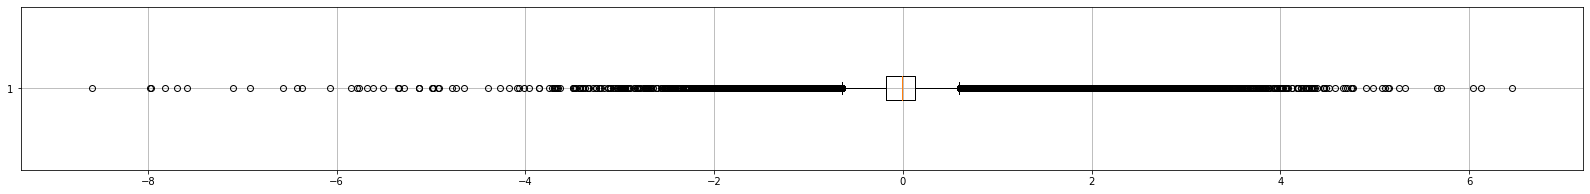

In [66]:
# Regresión polinómica de grado 2, aplicando L1 con alpha 0.001
# Diferencias entre el valor predicho y el valor real sobre el set de validación
plt.figure(figsize = (28, 3))
plt.boxplot((Y_validation - df_lasso_valid.reshape(80626,1)), vert = False)
plt.grid()
plt.show()

Se podría concluir que este modelo no presenta underfitting. Sin embargo, el modelo se comporta igual o mejor sin aplicar regularización.

### 4. Regresión Polinomial con regularización RIDGE (L2)

In [67]:
# Selección del mejor modelo de regresión con transformación polinomial de grado 1, 2 y 3, y regularización L2
estimators = [('polyRegression',PolynomialFeatures(degree=2, include_bias=False)),
              ('RidgeRegression', Ridge(alpha=1.0, solver='cholesky')),
             ]

pipe = Pipeline(estimators)

param_grid = dict(polyRegression__degree=[1, 2],
                  RidgeRegression__alpha= [0.1,1.0],
                  RidgeRegression__solver= ['cholesky'])

grid_search = GridSearchCV(pipe, param_grid=param_grid,cv=5,verbose=3)

grid_search.fit(X_train_scaled,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END RidgeRegression__alpha=0.1, RidgeRegression__solver=cholesky, polyRegression__degree=1;, score=0.524 total time=   0.2s
[CV 2/5] END RidgeRegression__alpha=0.1, RidgeRegression__solver=cholesky, polyRegression__degree=1;, score=0.529 total time=   0.1s
[CV 3/5] END RidgeRegression__alpha=0.1, RidgeRegression__solver=cholesky, polyRegression__degree=1;, score=0.527 total time=   0.1s
[CV 4/5] END RidgeRegression__alpha=0.1, RidgeRegression__solver=cholesky, polyRegression__degree=1;, score=0.530 total time=   0.1s
[CV 5/5] END RidgeRegression__alpha=0.1, RidgeRegression__solver=cholesky, polyRegression__degree=1;, score=0.528 total time=   0.1s
[CV 1/5] END RidgeRegression__alpha=0.1, RidgeRegression__solver=cholesky, polyRegression__degree=2;, score=0.756 total time=   2.0s
[CV 2/5] END RidgeRegression__alpha=0.1, RidgeRegression__solver=cholesky, polyRegression__degree=2;, score=0.763 total time=   2.3s
[CV 3/5] 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polyRegression',
                                        PolynomialFeatures(include_bias=False)),
                                       ('RidgeRegression',
                                        Ridge(solver='cholesky'))]),
             param_grid={'RidgeRegression__alpha': [0.1, 1.0],
                         'RidgeRegression__solver': ['cholesky'],
                         'polyRegression__degree': [1, 2]},
             verbose=3)

In [68]:
print(grid_search.best_params_)

{'RidgeRegression__alpha': 0.1, 'RidgeRegression__solver': 'cholesky', 'polyRegression__degree': 2}


In [69]:
# Creación de un modelo con transformación polinómica de grado 2 y alpha 0.1, ya que gridSearch indicó que era el mejor parámetro
poly_features = PolynomialFeatures(degree=2, include_bias=False)

x_poly_train = poly_features.fit_transform(X_train_scaled)
x_poly_test = poly_features.transform(X_test_scaled)
x_poly_valid = poly_features.transform(X_validation_scaled)

ridge_df = Ridge(alpha=0.1, solver='cholesky')
ridge_df.fit(x_poly_train, Y_train)
df_poly_training = ridge_df.predict(x_poly_train)
df_poly_valid = ridge_df.predict(x_poly_valid)
df_poly_test = ridge_df.predict(x_poly_test)

In [70]:
#Calculo del MAE
MAE_RidgeRegretion_train=mean_absolute_error(Y_train, df_poly_training)
MAE_RidgeRegretion_valid=mean_absolute_error(Y_validation, df_poly_valid)
MAE_RidgeRegretion_test=mean_absolute_error(Y_test, df_poly_test)

In [71]:
#Calculo del RMSE
RMSE_RidgeRegretion_train=np.sqrt(mean_squared_error(Y_train, df_poly_training))
RMSE_RidgeRegretion_valid=np.sqrt(mean_squared_error(Y_validation, df_poly_valid))
RMSE_RidgeRegretion_test=np.sqrt(mean_squared_error(Y_test, df_poly_test))
print(RMSE_RidgeRegretion_train, RMSE_RidgeRegretion_valid, RMSE_RidgeRegretion_test)

0.5174209725229936 0.5173475177534881 0.514761035157337


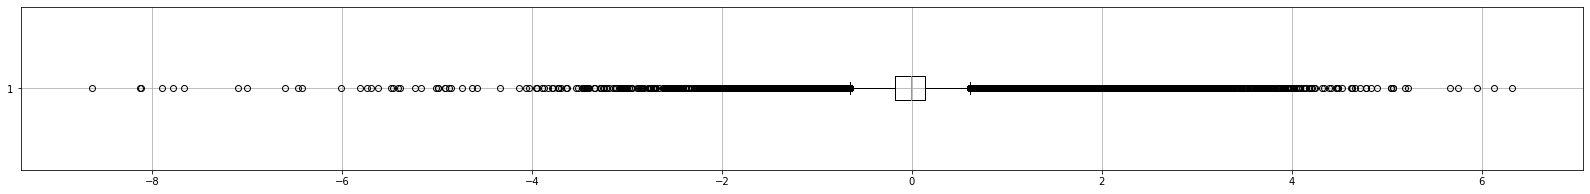

In [72]:
# Regresión polinómica de grado 2, aplicando L2 con alpha 0.1
# Diferencias entre el valor predicho y el valor real sobre el set de validación
plt.figure(figsize = (28, 3))
plt.boxplot((Y_validation - df_poly_valid), vert = False)
plt.grid()
plt.show()

Con base en la gráfica anterior se podría concluir que este modelo no presenta underfitting. Sin embargo, el modelo se comporta igual que sin aplicar regularización.


### 5. Árboles de Decisión

In [73]:
# Selección del mejor modelo de regresión basado en árboles de decisión, evaluando profundidad 5, 10, 15, 20 y 25
estimators = [('treeLevels',DecisionTreeRegressor(max_depth=2)),
              ]
pipe = Pipeline(estimators)

param_grid = dict(treeLevels__max_depth=[5, 10, 15, 20, 25],
                 treeLevels__splitter=['best', 'random'])

grid_search = GridSearchCV(pipe, param_grid=param_grid,cv=5,verbose=3)

grid_search.fit(X_train_scaled,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END treeLevels__max_depth=5, treeLevels__splitter=best;, score=0.831 total time=   1.4s
[CV 2/5] END treeLevels__max_depth=5, treeLevels__splitter=best;, score=0.832 total time=   1.3s
[CV 3/5] END treeLevels__max_depth=5, treeLevels__splitter=best;, score=0.832 total time=   1.4s
[CV 4/5] END treeLevels__max_depth=5, treeLevels__splitter=best;, score=0.835 total time=   1.3s
[CV 5/5] END treeLevels__max_depth=5, treeLevels__splitter=best;, score=0.833 total time=   1.3s
[CV 1/5] END treeLevels__max_depth=5, treeLevels__splitter=random;, score=0.200 total time=   0.3s
[CV 2/5] END treeLevels__max_depth=5, treeLevels__splitter=random;, score=0.349 total time=   0.3s
[CV 3/5] END treeLevels__max_depth=5, treeLevels__splitter=random;, score=0.571 total time=   0.3s
[CV 4/5] END treeLevels__max_depth=5, treeLevels__splitter=random;, score=0.483 total time=   0.3s
[CV 5/5] END treeLevels__max_depth=5, treeLevels__splitter

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('treeLevels',
                                        DecisionTreeRegressor(max_depth=2))]),
             param_grid={'treeLevels__max_depth': [5, 10, 15, 20, 25],
                         'treeLevels__splitter': ['best', 'random']},
             verbose=3)

In [74]:
print(grid_search.best_params_)

{'treeLevels__max_depth': 25, 'treeLevels__splitter': 'best'}


In [75]:
# Creación de un modelo de regresión basado en árboles de decisión, con grado de profundidad 25, según lo sugerido por gridSearch
dtr = DecisionTreeRegressor(max_depth=25, splitter='best')
dtr.fit(X_train_scaled, Y_train)

DecisionTreeRegressor(max_depth=25)

In [76]:
y1_train = dtr.predict(X_train_scaled)
y1_valid = dtr.predict(X_validation_scaled)
y1_test = dtr.predict(X_test_scaled)

In [77]:
#Calculo del MAE
MAE_DecisionTreeLevel_train=mean_absolute_error(Y_train, y1_train)
MAE_DecisionTreeLevel_valid=mean_absolute_error(Y_validation, y1_valid) 
MAE_DecisionTreeLevel_test=mean_absolute_error(Y_test, y1_test)

In [78]:
#Calculo del RMSE
RMSE_DecisionTreeLevel_train=np.sqrt(mean_squared_error(Y_train, y1_train))
RMSE_DecisionTreeLevel_valid=np.sqrt(mean_squared_error(Y_validation, y1_valid))
RMSE_DecisionTreeLevel_test=np.sqrt(mean_squared_error(Y_test, y1_test))
print(RMSE_DecisionTreeLevel_train, RMSE_DecisionTreeLevel_valid, RMSE_DecisionTreeLevel_test)

0.06695472111156885 0.2645517180708212 0.26288906733045764


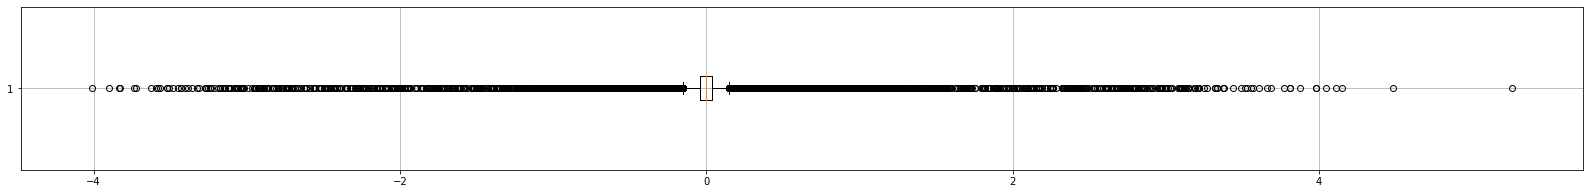

In [79]:
# Regresión basado en árboles de decisión, con grado de profundidad 25
# Diferencias entre el valor predicho y el valor real sobre el set de validación
plt.figure(figsize = (28, 3))
plt.boxplot((Y_validation - y1_valid.reshape(80626, 1)), vert = False)
plt.grid()
plt.show()

De acuerdo con la gráfica anterior, se podría concluir que aunque en este modelo se presentan mayores diferencias entre el error de entrenamiento y el erorr de validación, esas diferencias no son tan significativas como para considerar que existe underfitting. Por otro lado, es el modelo que presenta un menor error entre todos los entrenados.

## Punto 4 [25%]: Evaluación de los Modelos

### Creación del dataframe con resultados de cada modelo

In [80]:
ResultsDF = pd.DataFrame(columns=["Modelo", "Indicador", "Entrenamiento", "Validacion", "Prueba" ])

In [81]:
ResultsDF = ResultsDF.append({"Modelo":"Regresion lineal simple",
                                  "Indicador": "MAE",
                                  "Entrenamiento": MAE_LinealRegression_train,
                                  "Validacion": MAE_LinealRegression_valid,
                                  "Prueba" : MAE_LinealRegression_test }, ignore_index=True)

In [82]:
ResultsDF = ResultsDF.append({"Modelo":"Regresion Polinomial sin regularización",
                                  "Indicador": "MAE",
                                  "Entrenamiento": MAE_PolynomialRegression_train,
                                  "Validacion": MAE_PolynomialRegression_valid,
                                  "Prueba" : MAE_PolynomialRegression_test }, ignore_index=True)

In [83]:
ResultsDF = ResultsDF.append({"Modelo":"Regresion Polinomial Lasso L1",
                                  "Indicador": "MAE",
                                  "Entrenamiento": MAE_RidgeRegretion_train,
                                  "Validacion": MAE_RidgeRegretion_valid,
                                  "Prueba" : MAE_RidgeRegretion_test }, ignore_index=True)

In [84]:
ResultsDF = ResultsDF.append({"Modelo":"Regresion Polinomial Ridge L2",
                                  "Indicador": "MAE",
                                  "Entrenamiento": MAE_Lasso_train,
                                  "Validacion": MAE_Lasso_valid,
                                  "Prueba" : MAE_Lasso_test }, ignore_index=True)

In [85]:
ResultsDF = ResultsDF.append({"Modelo":"Arbol de Decisión",
                                  "Indicador": "MAE",
                                  "Entrenamiento": MAE_DecisionTreeLevel_train,
                                  "Validacion": MAE_DecisionTreeLevel_valid,
                                  "Prueba" : MAE_DecisionTreeLevel_test }, ignore_index=True)

In [86]:
ResultsDF = ResultsDF.append({"Modelo":"Regresion lineal simple",
                                  "Indicador": "RMSE",
                                  "Entrenamiento": RMSE_LinealRegression_train,
                                  "Validacion": RMSE_LinealRegression_valid,
                                  "Prueba" : RMSE_LinealRegression_test }, ignore_index=True)

In [87]:
ResultsDF = ResultsDF.append({"Modelo":"Regresion Polinomial sin regularización",
                                  "Indicador": "RMSE",
                                  "Entrenamiento": RMSE_PolynomialRegression_train,
                                  "Validacion": RMSE_PolynomialRegression_valid,
                                  "Prueba" : RMSE_PolynomialRegression_test }, ignore_index=True)

In [88]:
ResultsDF = ResultsDF.append({"Modelo":"Regresion Polinomial Lasso L1",
                                  "Indicador": "RMSE",
                                  "Entrenamiento": RMSE_Lasso_train,
                                  "Validacion": RMSE_Lasso_valid,
                                  "Prueba" : RMSE_Lasso_test }, ignore_index=True)

In [89]:
ResultsDF = ResultsDF.append({"Modelo":"Regresion Polinomial Ridge L2",
                                  "Indicador": "RMSE",
                                  "Entrenamiento": RMSE_RidgeRegretion_train,
                                  "Validacion": RMSE_RidgeRegretion_valid,
                                  "Prueba" : RMSE_RidgeRegretion_test }, ignore_index=True)

In [90]:
ResultsDF = ResultsDF.append({"Modelo":"Arbol de Decisión",
                                  "Indicador": "RMSE",
                                  "Entrenamiento": RMSE_DecisionTreeLevel_train,
                                  "Validacion": RMSE_DecisionTreeLevel_valid,
                                  "Prueba" : RMSE_DecisionTreeLevel_test }, ignore_index=True)

### Evaluación de los modelos

In [91]:
ResultsDF['Diferencia'] = ResultsDF['Entrenamiento'] - ResultsDF['Prueba']
ResultsDF

,Modelo,Indicador,Entrenamiento,Validacion,Prueba,Diferencia
0,Regresion lineal simple,MAE,0.37206,0.371423,0.370711,0.001349
1,Regresion Polinomial sin regularización,MAE,0.200715,0.204782,0.205776,-0.005061
2,Regresion Polinomial Lasso L1,MAE,0.276845,0.277228,0.275934,0.000911
3,Regresion Polinomial Ridge L2,MAE,0.275894,0.276399,0.274793,0.001101
4,Arbol de Decisión,MAE,0.03489,0.097089,0.096437,-0.061547
5,Regresion lineal simple,RMSE,0.727474,0.727264,0.723218,0.004256
6,Regresion Polinomial sin regularización,RMSE,0.391681,0.401929,0.407514,-0.015832
7,Regresion Polinomial Lasso L1,RMSE,0.520456,0.520371,0.517575,0.002881
8,Regresion Polinomial Ridge L2,RMSE,0.517421,0.517348,0.514761,0.00266
9,Arbol de Decisión,RMSE,0.066955,0.264552,0.262889,-0.195934


A partir de la gráfica anterior se puede concluir que en general los modelos no presentan problemas de underfitting. La diferencia presente en el modelo de árboles de decisión con 25 nodos, evaluado para el set de entrenamiento y prueba, no es significativa desde nuestro punto de vista para catalogarlo como underfitting. En este caso el modelo de árboles de decisión sería el que mejor predice la cantidad de energía que el usuario va a consumir.

### Evaluación del mejor modelo identificado

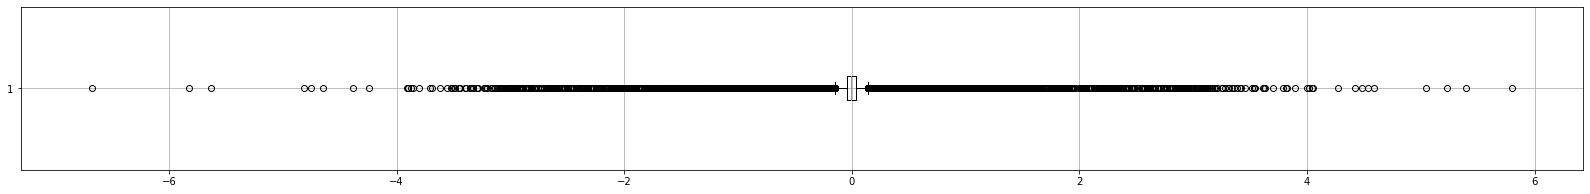

In [92]:
# Regresión basado en árboles de decisión, con grado de profundidad 25
# Diferencias entre el valor predicho y el valor real para el set de prueba
plt.figure(figsize = (28, 3))
plt.boxplot((Y_test - y1_test.reshape(100782, 1)), vert = False)
plt.grid()
plt.show()

In [93]:
# Identificación de casos con diferencias mayores a 0.5 entre la energía consumido real y la energía consumida calculada
worst_condition = np.where((Y_test - y1_test.reshape(100782, 1)) > 0.5, True, False)

worst_cases = pd.concat([
    X_test.loc[worst_condition],
    Y_test.loc[worst_condition]
], axis = 1).reset_index(drop = True)

worst_cases['predictions'] = pd.Series(y1_test).loc[worst_condition].reset_index(drop = True)
worst_cases.shape

(1365, 28)

De 80.626 registros que componen el set de prueba, el 1.35% presentan diferencias significativas. En consecuencia, el modelo se comporta bien y es aceptable, pero en el futuro se podría realizar un EDA sobre los casos errados para intentar identificar las variables que afectan ese consumo.

In [94]:
worst_cases

,Season,month,day,nday of week,Part of the Day,temperature,humidity,visibility,pressure,windSpeed,...,Wine cellar [kW],Garage door [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Furnace [kW],Kitchen [kW],use [kW],predictions
0,2,7,19,2,0,73.78,0.81,10.00,1009.83,5.63,...,0.008033,0.012400,0.029700,0.001000,0.004000,0.001767,0.085950,0.000483,3.420567,2.596583
1,3,10,27,4,0,27.05,0.89,9.95,1023.70,2.80,...,0.007567,0.011683,0.336583,0.001000,0.003600,0.331267,0.589000,0.001100,3.437667,2.259700
2,2,8,17,3,0,81.04,0.72,9.92,1014.62,4.50,...,0.149383,0.014783,0.026983,0.001717,0.003900,0.001633,0.985650,0.000467,10.444400,9.035900
3,1,3,21,1,0,48.63,0.43,10.00,1019.54,9.06,...,0.007083,0.011817,0.030667,0.721833,0.003967,0.329767,0.642300,0.000683,5.063567,2.294950
4,0,1,25,1,2,27.20,0.80,9.04,1018.56,7.10,...,0.007200,0.012367,0.029683,0.001017,0.004000,0.001583,1.156783,0.000633,1.787967,1.260025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,2,8,14,7,0,66.19,0.80,10.00,1011.68,8.82,...,0.152950,0.012517,0.030650,0.001000,0.003983,0.328017,0.088433,0.000333,1.439950,0.815181
1361,2,9,3,6,0,50.34,0.93,8.74,1023.81,1.87,...,0.161550,0.012833,0.650833,0.001133,0.003833,0.001467,0.088633,0.135467,1.237767,0.688830
1362,0,1,4,1,0,30.56,0.76,9.72,1010.26,6.39,...,0.006967,0.012583,0.030183,0.001033,0.003933,0.099717,0.596667,0.000883,1.934133,1.173933
1363,2,8,11,4,0,62.74,0.89,9.96,1014.48,0.27,...,0.025567,0.012217,0.149033,0.001367,0.003967,0.001550,1.253533,0.000700,5.797650,4.852200


<AxesSubplot:xlabel='Part of the Day'>

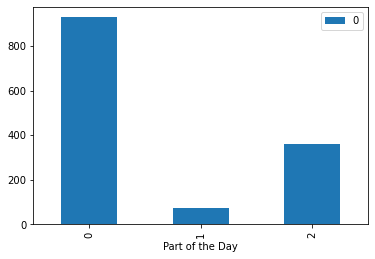

In [95]:
# Diagrama de frecuencias para el campo Part of the day
consumo_icon = worst_cases.groupby("Part of the Day").size().reset_index()
consumo_icon.plot('Part of the Day', kind = 'bar')

## Punto 5 [15%]: Conclusiones

Ver documento